In [1]:
from All_functions_simulation_univariate import * 
from All_Functions_FF import my_plot 
from sklearn.linear_model import QuantileRegressor

In [2]:
##################### Data preparation ###################

data = pd.read_csv('FFData.CSV')

MKT = data["Mkt-RF"]
MKT = MKT.to_numpy().reshape(-1,1)

SMB = data["SMB"]
SMB = SMB.to_numpy().reshape(-1,1)

HML = data["HML"]
HML = HML.to_numpy().reshape(-1,1)

RF = data["RF"]
RF = RF.to_numpy().reshape(-1,1)


# monthly data
index_1927 = data["Year"].to_list().index(1927)
MKT_te = MKT[0:index_1927-1,:]
SMB_te = SMB[0:index_1927-1,:]
HML_te = HML[0:index_1927-1,:]
RF_te = RF[0:index_1927-1,:]


# data standardization
MKT_te =(MKT_te-np.mean(MKT_te))/np.std(MKT_te)
SMB_te =(SMB_te-np.mean(SMB_te))/np.std(SMB_te)
HML_te =(HML_te-np.mean(HML_te))/np.std(HML_te)
RF_te =(RF_te-np.mean(RF_te))/np.std(RF_te)

In [6]:
############################### UTOPIA, SplitCF, LQR function #################################

def UTOPIA_FF(train_data, test_data, verbose, max_depth = 5): 
    
    X_pre = train_data[:500,0].reshape(-1,1)
    Y_pre = train_data[:500,1].reshape(-1,1)

    X_opt = train_data[500:700,0].reshape(-1,1)
    Y_opt = train_data[500:700,1].reshape(-1,1)

    X_adj = train_data[700:,0].reshape(-1,1)
    Y_adj = train_data[700:,1].reshape(-1,1)


    X_t = test_data[:,0].reshape(-1,1)
    Y_t = test_data[:,1].reshape(-1,1)



    n_pre = len(X_pre)
    n_opt = len(X_opt)
    n_adj = len(X_adj)
    n_t = len(X_t)

    M_pre, M_opt, M_adj, M_t = mean_est("NN2", X_pre,Y_pre,X_opt,X_adj,X_t)
    var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t, max_depth, "RF")

    quantile = [0.05,0.35,0.65,0.95]
    m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
    m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
    m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
    m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

    # construct estimator matrix
    E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt.reshape(-1, 1)))
    E_opt = E_opt.T
    E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj.reshape(-1, 1)))
    E_adj = E_adj.T
    E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t.reshape(-1, 1)))
    E_t = E_t.T

    optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)

    alpha = 0.05
    delta = interval_adj_2(X_adj,Y_adj,M_adj,V100_adj,alpha)

    V_alpha_t = delta*V100_t
    
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    bandwidth_med = np.median(V_alpha_t[:,0])
    
    if verbose: 
        print("The overall coverage for UTOPIA is", coverage)
        print("The mean bandwidth for testing data of UTOPIA is", bandwidth)
        print("The median bandwidth for testing data of UTOPIA is", bandwidth_med)
    
    return coverage, bandwidth, bandwidth_med
    
    
def LQR_FF(train_data, test_data, verbose):
    X_lin = train_data[:,0].reshape(-1,1)
    Y_lin = train_data[:,1].reshape(-1,1)
    y_lin = Y_lin[:,0]
    X_quantile = train_data[:,0].reshape(-1,1)
    Y_quantile = train_data[:,1].reshape(-1,1)
    X_test = test_data[:,0].reshape(-1,1)
    Y_test = test_data[:,1].reshape(-1,1)

    M_quantile, M_test = mean_est_2("NN1",X_lin,Y_lin,X_quantile,X_test)


    alpha = 0.05
    model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0,solver='highs')
    model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
    Q_test = model_quantile.predict(X_test)


    V_test = Q_test**2
    V_test = V_test.reshape(-1,1)

    coverage = (np.power(Y_test[:,0]-M_test[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    bandwidth_med = np.median(V_test[:,0])
    
    if verbose: 
        print("The overall coverage for LQR is", coverage)
        print("The mean bandwidth for testing data of LQR is", bandwidth)
        print("The median bandwidth for testing data LQR is", bandwidth_med)
    
    return coverage, bandwidth, bandwidth_med



def var_adjusted_SCF(train_data, test_data, verbose, max_depth = 5):
    
    
    X_mean = train_data[:500,0].reshape(-1,1)
    Y_mean = train_data[:500,1].reshape(-1,1)

    X_res = train_data[500:,0].reshape(-1,1)
    Y_res = train_data[500:,1].reshape(-1,1)

    X_test = test_data[:,0].reshape(-1,1)
    Y_test = test_data[:,1].reshape(-1,1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42) 
    input_dim = X_mean.shape[1]
    model = NN2(input_size=input_dim, output_size=1).to(device)
    criterion=nn.MSELoss()
    learning_rate = 0.001
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(1000):
        inputs=Variable(torch.from_numpy(X_mean))
        labels=Variable(torch.from_numpy(Y_mean))
        optimizer.zero_grad()
        outputs=model(inputs.float())
        loss=criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()


    Y_mean_hat = model(torch.from_numpy(X_mean).float())
    Y_mean_hat = Y_mean_hat.detach().cpu().numpy().reshape(-1,1)

    Y_res_hat = model(torch.from_numpy(X_res).float())
    Y_res_hat = Y_res_hat.detach().cpu().numpy().reshape(-1,1)

    Y_test_hat = model(torch.from_numpy(X_test).float())
    Y_test_hat = Y_test_hat.detach().cpu().numpy().reshape(-1,1)


    resid_mean = Y_mean[:,0] - Y_mean_hat[:,0]


    ########################### RF based conditional variance estimator ##########################

    var_model = RandomForestRegressor(n_estimators = 1000, max_depth = max_depth, random_state = 42)
    #var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 3)
    var_model.fit(X_mean, resid_mean ** 2)

    var_mean_hat = var_model.predict(X_mean)
    var_res_hat = var_model.predict(X_res)
    var_test_hat = var_model.predict(X_test)

    alpha = 0.05
    residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
    k = int((1 - alpha) * len(residuals))
    residuals_sorted = np.sort(residuals)
    threshold = residuals_sorted[k]

    v_test = (threshold**2)*var_test_hat
    V_test = v_test.reshape(-1,1)


    # ########################### NN1 based conditional variance estimator ##########################

    # input_dim = X_mean.shape[0]
    # X = X_mean.reshape(-1,)
    # Y = resid_mean ** 2
    # Y = Y.reshape(-1,)
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # torch.manual_seed(42)
    # torch.cuda.manual_seed_all(42) 
    # model = NN1(input_size=input_dim, output_size=1).to(device)
    # criterion=nn.MSELoss()
    # learning_rate = 0.001
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # for epoch in range(1000):
    #     #convert numpy array to torch Variable
    #     inputs=Variable(torch.from_numpy(X))
    #     labels=Variable(torch.from_numpy(Y))

    #     #clear gradients wrt parameters
    #     optimizer.zero_grad()

    #     #Forward to get outputs
    #     outputs=model(inputs.float())

    #     #calculate loss
    #     loss=criterion(outputs.float(), labels.float())

    #     #getting gradients wrt parameters
    #     loss.backward()

    #     #updating parameters
    #     optimizer.step()


    # var_res_hat = model(torch.from_numpy(X_res).float()).detach().cpu().numpy().reshape(-1,1)
    # var_test_hat = model(torch.from_numpy(X_test).float()).detach().cpu().numpy().reshape(-1,1)

    alpha = 0.05
    residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
    k = int((1 - alpha) * len(residuals))
    residuals_sorted = np.sort(residuals)
    threshold = residuals_sorted[k]

    v_test = (threshold**2)*var_test_hat
    V_test = v_test.reshape(-1,1)


    # plot 
    coverage = (np.power(Y_test[:,0]-Y_test_hat[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    bandwidth_med = np.median(V_test[:,0])
    
    if verbose:
        print("The overall coverage for VSC is", coverage)
        print("The mean bandwidth for testing data of VSC is", bandwidth)
        print("The median bandwidth for testing data of VSC is", bandwidth_med)

    return coverage, bandwidth, bandwidth_med
    
    

In [14]:
def value_generator(X_axis, Y_axis, verbose = False, seed = 10):
    
    X = X_axis
    Y = Y_axis

    Data = np.hstack([X,Y])
    Q1 = np.percentile(Y, 25, method = 'midpoint')
    Q3 = np.percentile(Y, 75, method = 'midpoint')
    IQR = Q3 - Q1
    upper=Q3+1.5*IQR
    upper_array=np.array(Y<=upper)
    lower=Q1-1.5*IQR
    lower_array=np.array(Y>=lower)
    index_keep = upper_array & lower_array
    Data = Data[index_keep[:,0].tolist(),:]
    print("By removing outliers w.r.t y, the number of data being removed is ", Y.shape[0]-Data.shape[0])

    np.random.seed(seed)
    np.random.shuffle(Data)
    train_idx = int(Data.shape[0] * 0.8)
    train_data, test_data = np.split(Data, [train_idx])
    
    coverage_u, bw_mean_u, bw_med_u = UTOPIA_FF(train_data, test_data, verbose, max_depth = 5)
    coverage_lqr, bw_mean_lqr, bw_med_lqr = LQR_FF(train_data, test_data, verbose)
    coverage_sc, bw_mean_sc, bw_med_sc = var_adjusted_SCF(train_data, test_data, verbose, max_depth = 5)
    
    return coverage_u, bw_mean_u, bw_med_u, coverage_lqr, bw_mean_lqr, bw_med_lqr, coverage_sc, bw_mean_sc, bw_med_sc

In [13]:
value_generator(MKT_te, RF_te, seed = 1)

By removing outliers w.r.t y, the number of data being removed is  17


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


(0.9606986899563319,
 3.1064557818959644,
 2.878937735996375,
 0.982532751091703,
 4.297160448818103,
 4.267515411383636,
 0.9650655021834061,
 3.618611177466745,
 3.2990819184140903)

In [15]:
Iter = 100
output_array = np.zeros((Iter, 9, 3))

def run_FF_parallel(j): 
    seed_now = j
    output_local = np.zeros((9, 3))
    output_local[:,0] = value_generator(MKT_te, SMB_te, seed = seed_now)
    output_local[:,1] = value_generator(MKT_te, RF_te, seed = seed_now)
    output_local[:,2] = value_generator(MKT_te, HML_te, seed = seed_now)
    
    return output_local

In [17]:
times = 100
from joblib import Parallel, delayed
results = Parallel(n_jobs=10)(delayed(run_FF_parallel)(i) for i in range(times))

output_global = np.zeros((times, 9, 3))
for j in range(times):
    output_global[j,:,:] = results[j]
    
print(output_global.mean(axis = 0))

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Drop

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Drop

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Drop

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Drop

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Drop

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Drop

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Drop

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Drop

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Drop

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Drop

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/BOSTON UNIVERSITY Drop

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


[[0.94561947 0.94759825 0.94757991]
 [2.49872435 3.25670543 1.99860259]
 [2.26102684 3.1296453  1.87418594]
 [0.95371681 0.97489083 0.95794521]
 [2.34508419 4.25270377 1.99731854]
 [2.34191802 4.2480878  1.97688101]
 [0.95026549 0.94943231 0.95228311]
 [2.74446223 3.45791189 2.20056562]
 [2.41806271 3.22304872 1.88967439]]
By removing outliers w.r.t y, the number of data being removed is  34
By removing outliers w.r.t y, the number of data being removed is  17
By removing outliers w.r.t y, the number of data being removed is  65
By removing outliers w.r.t y, the number of data being removed is  34
By removing outliers w.r.t y, the number of data being removed is  17
By removing outliers w.r.t y, the number of data being removed is  65
By removing outliers w.r.t y, the number of data being removed is  34
By removing outliers w.r.t y, the number of data being removed is  17
By removing outliers w.r.t y, the number of data being removed is  65
By removing outliers w.r.t y, the number of d

By removing outliers w.r.t y, the number of data being removed is  34
By removing outliers w.r.t y, the number of data being removed is  17
By removing outliers w.r.t y, the number of data being removed is  65
By removing outliers w.r.t y, the number of data being removed is  34
By removing outliers w.r.t y, the number of data being removed is  17
By removing outliers w.r.t y, the number of data being removed is  65
By removing outliers w.r.t y, the number of data being removed is  34
By removing outliers w.r.t y, the number of data being removed is  17
By removing outliers w.r.t y, the number of data being removed is  65
By removing outliers w.r.t y, the number of data being removed is  34
By removing outliers w.r.t y, the number of data being removed is  17
By removing outliers w.r.t y, the number of data being removed is  65
By removing outliers w.r.t y, the number of data being removed is  34
By removing outliers w.r.t y, the number of data being removed is  17
By removing outliers

By removing outliers w.r.t y, the number of data being removed is  34
By removing outliers w.r.t y, the number of data being removed is  17
By removing outliers w.r.t y, the number of data being removed is  65
By removing outliers w.r.t y, the number of data being removed is  34
By removing outliers w.r.t y, the number of data being removed is  17
By removing outliers w.r.t y, the number of data being removed is  65
By removing outliers w.r.t y, the number of data being removed is  34
By removing outliers w.r.t y, the number of data being removed is  17
By removing outliers w.r.t y, the number of data being removed is  65
By removing outliers w.r.t y, the number of data being removed is  34
By removing outliers w.r.t y, the number of data being removed is  17
By removing outliers w.r.t y, the number of data being removed is  65
By removing outliers w.r.t y, the number of data being removed is  34
By removing outliers w.r.t y, the number of data being removed is  17
By removing outliers

In [9]:
output_global = np.zeros((times, 9, 3))
for j in range(times):
    output_global[j,:,:] = results[j]

NameError: name 'times' is not defined

In [51]:
output_global.mean(axis = 0)

array([[0.9159292 , 0.94759825, 0.93150685],
       [2.32902052, 3.29571585, 1.78593587],
       [2.27490059, 3.27334215, 1.69230187],
       [0.91150442, 0.99126638, 0.91780822],
       [2.13569038, 4.44500615, 1.84954938],
       [2.13704788, 4.44337536, 1.848807  ],
       [0.9159292 , 0.95196507, 0.95890411],
       [2.39301464, 3.43004703, 2.43482942],
       [2.14028066, 3.3446923 , 2.13469021]])

In [34]:
############ Plots #############

############################### UTOPIA, SplitCF, LQR function #################################

def UTOPIA_FF(train_data, test_data, verbose, max_depth = 5): 
    
    X_pre = train_data[:500,0].reshape(-1,1)
    Y_pre = train_data[:500,1].reshape(-1,1)

    X_opt = train_data[500:700,0].reshape(-1,1)
    Y_opt = train_data[500:700,1].reshape(-1,1)

    X_adj = train_data[700:,0].reshape(-1,1)
    Y_adj = train_data[700:,1].reshape(-1,1)


    X_t = test_data[:,0].reshape(-1,1)
    Y_t = test_data[:,1].reshape(-1,1)



    n_pre = len(X_pre)
    n_opt = len(X_opt)
    n_adj = len(X_adj)
    n_t = len(X_t)

    M_pre, M_opt, M_adj, M_t = mean_est("NN2", X_pre,Y_pre,X_opt,X_adj,X_t)
    var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t, max_depth, "RF")

    quantile = [0.05,0.35,0.65,0.95]
    m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
    m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
    m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
    m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

    # construct estimator matrix
    E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt.reshape(-1, 1)))
    E_opt = E_opt.T
    E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj.reshape(-1, 1)))
    E_adj = E_adj.T
    E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t.reshape(-1, 1)))
    E_t = E_t.T

    optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)

    alpha = 0.05
    delta = interval_adj_2(X_adj,Y_adj,M_adj,V100_adj,alpha)

    V_alpha_t = delta*V100_t
    
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    bandwidth_med = np.median(V_alpha_t[:,0])
    
    if verbose: 
        print("The overall coverage for UTOPIA is", coverage)
        print("The mean bandwidth for testing data of UTOPIA is", bandwidth)
        print("The median bandwidth for testing data of UTOPIA is", bandwidth_med)
    
    my_plot(X_t,Y_t,M_t,V_alpha_t,X_axis = "MKT", Y_axis = "HML",ylim = [-4,4])
    
    return coverage, bandwidth, bandwidth_med
    
    
def LQR_FF(train_data, test_data, verbose):
    X_lin = train_data[:,0].reshape(-1,1)
    Y_lin = train_data[:,1].reshape(-1,1)
    y_lin = Y_lin[:,0]
    X_quantile = train_data[:,0].reshape(-1,1)
    Y_quantile = train_data[:,1].reshape(-1,1)
    X_test = test_data[:,0].reshape(-1,1)
    Y_test = test_data[:,1].reshape(-1,1)

    M_quantile, M_test = mean_est_2("NN1",X_lin,Y_lin,X_quantile,X_test)


    alpha = 0.05
    model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0,solver='highs')
    model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
    Q_test = model_quantile.predict(X_test)


    V_test = Q_test**2
    V_test = V_test.reshape(-1,1)

    coverage = (np.power(Y_test[:,0]-M_test[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    bandwidth_med = np.median(V_test[:,0])
    
    if verbose: 
        print("The overall coverage for LQR is", coverage)
        print("The mean bandwidth for testing data of LQR is", bandwidth)
        print("The median bandwidth for testing data LQR is", bandwidth_med)
    
    my_plot(X_test,Y_test,M_test,V_test,X_axis = "MKT", Y_axis = "HML",ylim=[-4,4])
    
    return coverage, bandwidth, bandwidth_med



def var_adjusted_SCF(train_data, test_data, verbose, max_depth = 5):
    
    
    X_mean = train_data[:500,0].reshape(-1,1)
    Y_mean = train_data[:500,1].reshape(-1,1)

    X_res = train_data[500:,0].reshape(-1,1)
    Y_res = train_data[500:,1].reshape(-1,1)

    X_test = test_data[:,0].reshape(-1,1)
    Y_test = test_data[:,1].reshape(-1,1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42) 
    input_dim = X_mean.shape[1]
    model = NN2(input_size=input_dim, output_size=1).to(device)
    criterion=nn.MSELoss()
    learning_rate = 0.001
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(1000):
        inputs=Variable(torch.from_numpy(X_mean))
        labels=Variable(torch.from_numpy(Y_mean))
        optimizer.zero_grad()
        outputs=model(inputs.float())
        loss=criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()


    Y_mean_hat = model(torch.from_numpy(X_mean).float())
    Y_mean_hat = Y_mean_hat.detach().cpu().numpy().reshape(-1,1)

    Y_res_hat = model(torch.from_numpy(X_res).float())
    Y_res_hat = Y_res_hat.detach().cpu().numpy().reshape(-1,1)

    Y_test_hat = model(torch.from_numpy(X_test).float())
    Y_test_hat = Y_test_hat.detach().cpu().numpy().reshape(-1,1)


    resid_mean = Y_mean[:,0] - Y_mean_hat[:,0]


    ########################### RF based conditional variance estimator ##########################

    var_model = RandomForestRegressor(n_estimators = 1000, max_depth = max_depth, random_state = 42)
    #var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 3)
    var_model.fit(X_mean, resid_mean ** 2)

    var_mean_hat = var_model.predict(X_mean)
    var_res_hat = var_model.predict(X_res)
    var_test_hat = var_model.predict(X_test)

    alpha = 0.05
    residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
    k = int((1 - alpha) * len(residuals))
    residuals_sorted = np.sort(residuals)
    threshold = residuals_sorted[k]

    v_test = (threshold**2)*var_test_hat
    V_test = v_test.reshape(-1,1)


    # ########################### NN1 based conditional variance estimator ##########################

    # input_dim = X_mean.shape[0]
    # X = X_mean.reshape(-1,)
    # Y = resid_mean ** 2
    # Y = Y.reshape(-1,)
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # torch.manual_seed(42)
    # torch.cuda.manual_seed_all(42) 
    # model = NN1(input_size=input_dim, output_size=1).to(device)
    # criterion=nn.MSELoss()
    # learning_rate = 0.001
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # for epoch in range(1000):
    #     #convert numpy array to torch Variable
    #     inputs=Variable(torch.from_numpy(X))
    #     labels=Variable(torch.from_numpy(Y))

    #     #clear gradients wrt parameters
    #     optimizer.zero_grad()

    #     #Forward to get outputs
    #     outputs=model(inputs.float())

    #     #calculate loss
    #     loss=criterion(outputs.float(), labels.float())

    #     #getting gradients wrt parameters
    #     loss.backward()

    #     #updating parameters
    #     optimizer.step()


    # var_res_hat = model(torch.from_numpy(X_res).float()).detach().cpu().numpy().reshape(-1,1)
    # var_test_hat = model(torch.from_numpy(X_test).float()).detach().cpu().numpy().reshape(-1,1)

    alpha = 0.05
    residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
    k = int((1 - alpha) * len(residuals))
    residuals_sorted = np.sort(residuals)
    threshold = residuals_sorted[k]

    v_test = (threshold**2)*var_test_hat
    V_test = v_test.reshape(-1,1)


    # plot 
    coverage = (np.power(Y_test[:,0]-Y_test_hat[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    bandwidth_med = np.median(V_test[:,0])
    
    if verbose:
        print("The overall coverage for VSC is", coverage)
        print("The mean bandwidth for testing data of VSC is", bandwidth)
        print("The median bandwidth for testing data of VSC is", bandwidth_med)


    my_plot(X_test,Y_test,Y_test_hat,V_test,X_axis = "MKT", Y_axis = "HML",ylim = [-4,4])
    
    return coverage, bandwidth, bandwidth_med
    
    

By removing outliers w.r.t y, the number of data being removed is  65


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


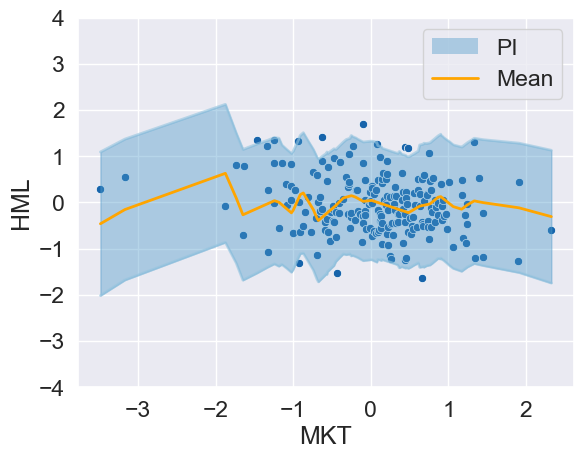

The overall coverage is 0.958904109589041
The mean bandwidth for testing data is 1.6467572600249694
The median bandwidth for testing data is 1.6478525103055068


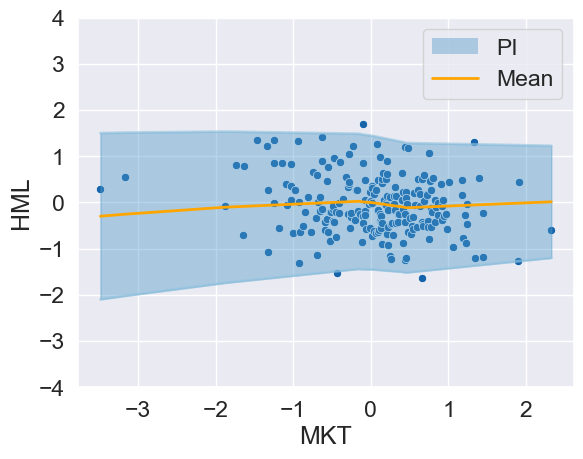

The overall coverage is 0.9771689497716894
The mean bandwidth for testing data is 2.087720210323887
The median bandwidth for testing data is 2.058872114995579


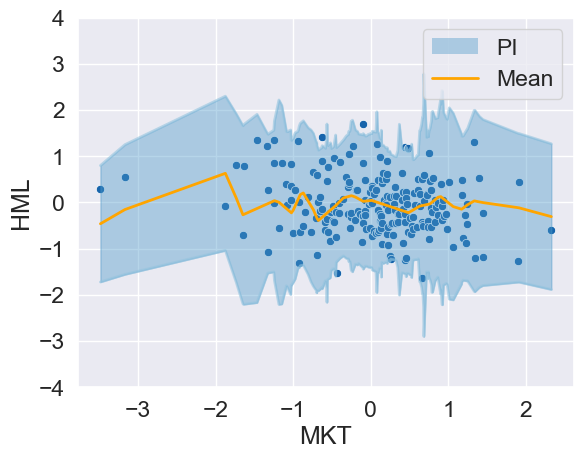

The overall coverage is 0.9726027397260274
The mean bandwidth for testing data is 2.363595486922711
The median bandwidth for testing data is 2.132922757660684


(0.958904109589041,
 1.6467572600249694,
 1.6478525103055068,
 0.9771689497716894,
 2.087720210323887,
 2.058872114995579,
 0.9726027397260274,
 2.363595486922711,
 2.132922757660684)

In [35]:
value_generator(MKT_te, HML_te, seed = 10)